In [1]:
%load_ext autoreload
%autoreload 2

import sys

not ".." in sys.path and sys.path.insert(0, "..")

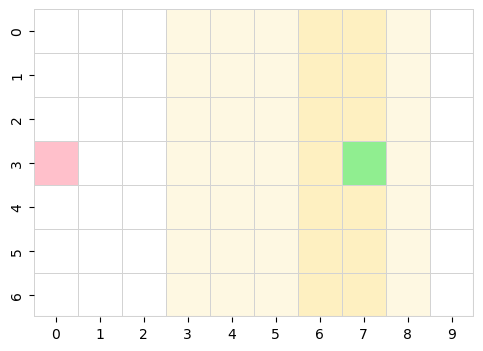

In [2]:
import numpy as np
from chapter_6.windy_gridworld import WindyGridWorld, sample_policy_episode


np.random.seed(42)

grid_world = WindyGridWorld()
grid_world.render()


Ep #460: 95 time steps. Convergence rate: 43.6%: 100%|██████████| 500/500 [01:13<00:00,  6.85it/s]  

Convergence rate: 47.4%


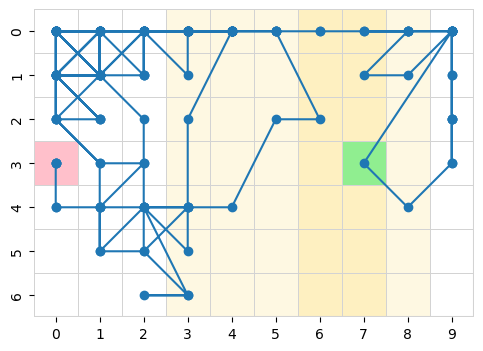

In [3]:
import logging
from tqdm import trange


def n_step_sarsa(
    env: WindyGridWorld,
    max_eps: int = 100,
    max_time: int = 20000,
    n=4,
    alpha=0.5,
    epsilon=0.1,
    discount=1,
):
    logging.info("Start training...")
    # Inititalize
    action_dim = len(env.action_space)
    state_action_dims = (*env.grid_map.shape, action_dim)
    Q = -max_time * np.ones(state_action_dims)
    behavior_policy = np.ones(Q.shape) / action_dim
    policy = np.ones(Q.shape) / action_dim

    temp_S = np.full(n + 1, None)
    temp_A = np.full(n + 1, None)
    temp_R = np.full(n + 1, None)
    temp_rho = np.full(n + 1, None)
    temp_sigma = np.full(n + 1, None)

    def choose_action(state: tuple):
        return np.random.choice(action_dim, p=behavior_policy[state])

    state_history = [env.current_state]
    progress_bar = trange(max_eps)
    converged_count = 0
    for ep_num in progress_bar:
        env.reset()
        state = tuple(env.current_state)
        action = choose_action(state)
        temp_S[0] = state
        temp_A[0] = action
        T = max_time

        state_history = [env.current_state]
        for t in range(max_time):
            temp_idx = (t + 1) % (n + 1)
            next_state_action = None
            if t < T:
                reward, finished = env.step(env.action_space[action])
                next_state = tuple(env.current_state)

                temp_S[temp_idx] = next_state
                temp_R[temp_idx] = reward

                if finished:
                    T = t + 1
                    converged_count += 1
                    if ep_num % 20 == 0:
                        progress_bar.set_description(
                            f"Ep #{ep_num}: {t} time steps. Convergence rate: {round(converged_count * 100 / max_eps, 2)}%"
                        )
                else:
                    next_action = choose_action(next_state)
                    temp_A[temp_idx] = next_action
                    temp_sigma[temp_idx] = np.random.random()
                    next_state_action = (*next_state, next_action)
                    temp_rho[temp_idx] = (
                        policy[next_state_action] / behavior_policy[next_state_action]
                    )

            tau = t - n + 1
            if tau >= 0:
                G = 0
                if t + 1 < T:
                    G = Q[next_state_action]

                for k in range(min(t + 1, T), tau, -1):
                    idx_k = k % (n + 1)
                    reward_k = temp_R[idx_k]
                    if k == T:
                        G = reward_k
                    else:
                        state_k = temp_S[idx_k]
                        expected_V = policy[state_k].dot(Q[state_k])

                        state_action_k = (*state_k, temp_A[idx_k])
                        sigma_k, rho_k = temp_sigma[idx_k], temp_rho[idx_k]
                        G = (
                            temp_R[idx_k]
                            + discount
                            * (sigma_k * rho_k + (1 - rho_k) * policy[state_action_k])
                            * (G - Q[state_action_k])
                            + discount * expected_V
                        )

                idx_tau = tau % (n + 1)
                state_action = (*temp_S[idx_tau], temp_A[idx_tau])
                Q[state_action] += alpha * (G - Q[state_action])

                # Ensure policy is epsilon-greedy wrt to Q
                policy[temp_S[idx_tau]] = epsilon / action_dim
                policy[(*temp_S[idx_tau], np.argmax(Q[temp_S[idx_tau]]))] = (
                    1 - epsilon + epsilon / action_dim
                )

            state = temp_S[temp_idx]
            action = temp_A[temp_idx]
            state_history.append(state)

            if tau == T - 1:
                break

    print(f"Convergence rate: {round(converged_count * 100 / max_eps, 2)}%")
    env.render(state_history)
    policy = np.argmax(Q, axis=-1)
    return Q, policy


Q, policy = n_step_sarsa(
    grid_world, max_eps=500, max_time=2000, n=8, epsilon=0.2, alpha=0.1
)


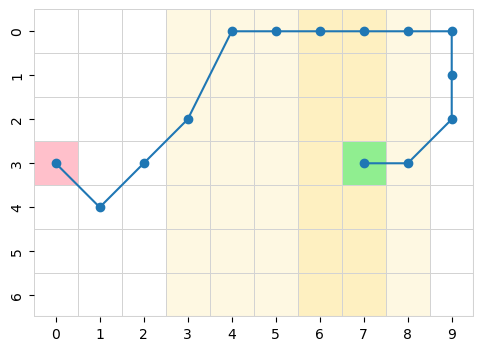

In [4]:
sample_policy_episode(grid_world, policy, 15)